In [1]:
#!pip install qiskit --upgrade
!pip install qiskit[visualization] --quiet

In [2]:
import math
import qiskit
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from qiskit_aer.backends import AerSimulator
from qiskit.quantum_info import Statevector, random_statevector, Pauli, SparsePauliOp
from qiskit.visualization import plot_bloch_multivector
from qiskit.primitives import Estimator


# Exercise 3

In [3]:
def teleport(StateVector):

    circ_q = qiskit.QuantumRegister(3, name='q')
    circ_c = qiskit.ClassicalRegister(1, name='c')
    circ = qiskit.QuantumCircuit(circ_q, circ_c)
    circ.initialize(StateVector, circ_q[0])
    
    circ.h(circ_q[2])
    circ.cx(circ_q[2], circ_q[1])
    
    circ.barrier()
    circ.cx(circ_q[0], circ_q[1])
    circ.h(circ_q[0])
    
    circ.barrier()
    circ.measure(circ_q[1], circ_c)
    circ.x(circ_q[2]).c_if(circ_c, 1)
    
    circ.measure(circ_q[0], circ_c)
    circ.z(circ_q[2]).c_if(circ_c, 1)
    
    return circ

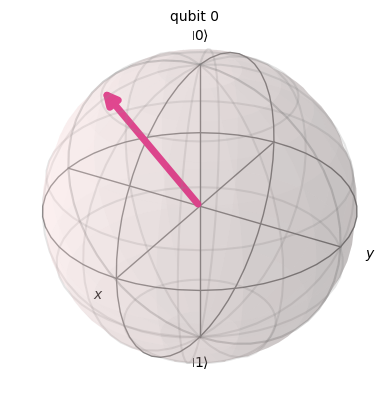

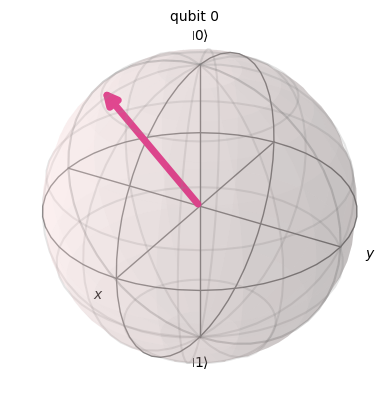

In [4]:
rand = random_statevector(2)
plot_bloch_multivector(rand)

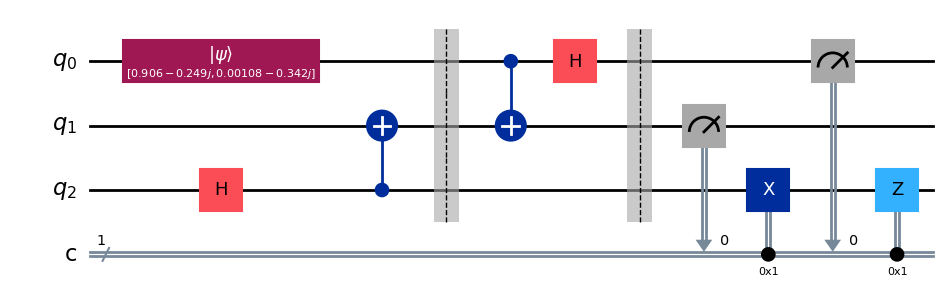

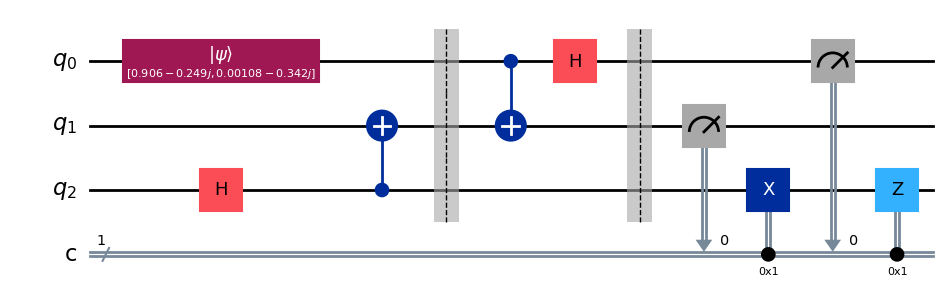

In [5]:
teleported_circuit = teleport(rand)

teleported_circuit.draw('mpl')

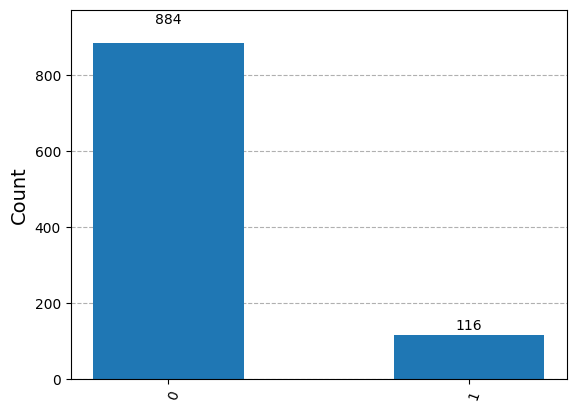

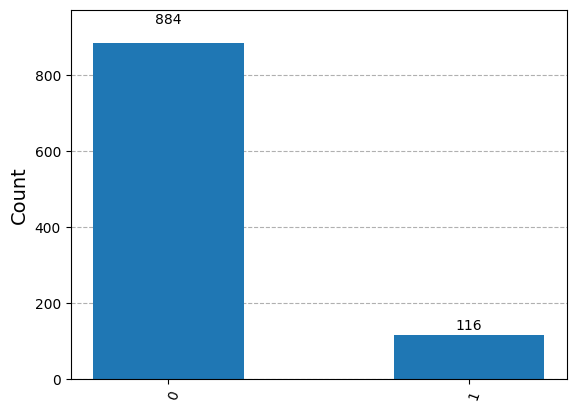

In [6]:
sim = AerSimulator(method="statevector")

N_shots = 1000  # number of measurements

teleported_circuit.save_statevector()  # save statevector at the end of the circuit
teleported_state = sim.run(teleported_circuit).result().get_statevector()

teleported_circuit.measure(2, 0)

result = sim.run(teleported_circuit, shots=N_shots).result()
counts = result.get_counts(teleported_circuit)

from qiskit.visualization import plot_histogram
plot_histogram(counts)

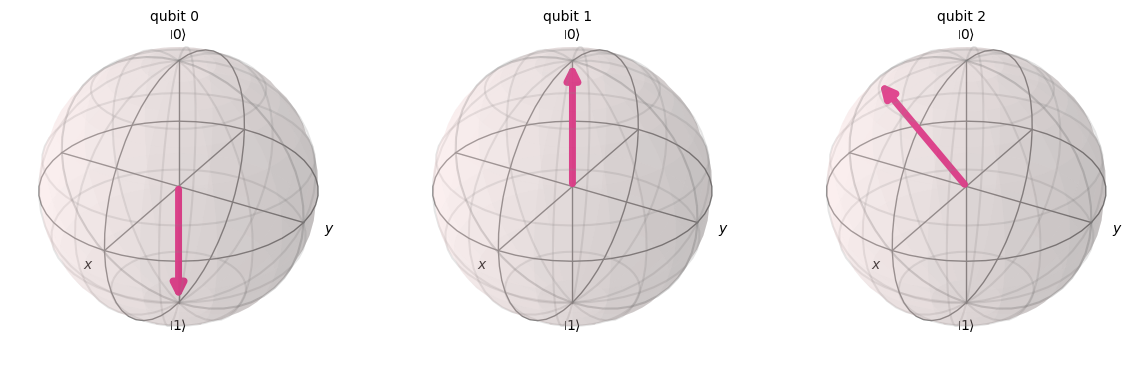

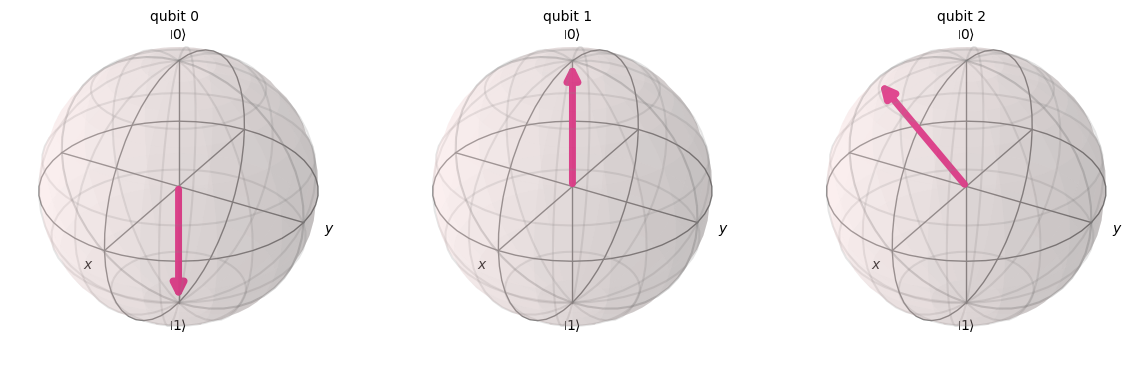

In [7]:
plot_bloch_multivector(teleported_state)

# Exercise 11

In [14]:
def parametrized_circuit(a, b):

    circ_q = qiskit.QuantumRegister(2, name='q')
    circ = qiskit.QuantumCircuit(circ_q)

    circ.h(1)
    circ.rzz(-2*b, circ_q[0], circ_q[1])
    circ.h(1)
    
    circ.barrier()
    circ.h(0)
    circ.rzz(-2*b, circ_q[0], circ_q[1])
    circ.h(0)
    
    circ.barrier()
    circ.rz(-2*a, circ_q[0])
    circ.rz(-2*a, circ_q[1])
 
    return circ


# Exercise 12

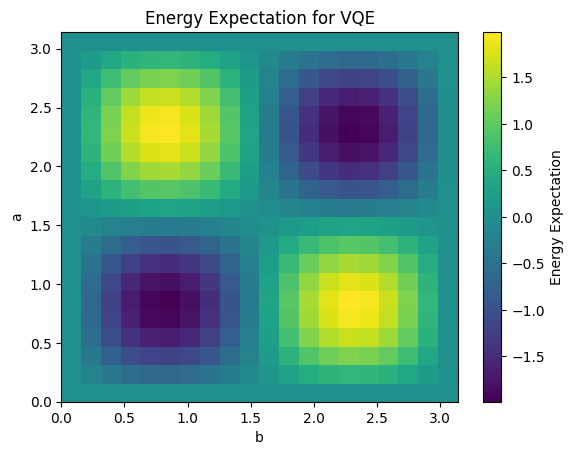

Minimum energy: -1.9863613034027208 at a = 0.8267349088394192, b = 0.8267349088394192


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import transpile
from qiskit.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp

H = SparsePauliOp.from_list([("XZ", -1), ("ZX", -1)])

# Prepare the grid search parameters
nmbr_points = 20
a_array = np.linspace(0, np.pi, nmbr_points)
b_array = np.linspace(0, np.pi, nmbr_points)
expectation_value = np.zeros((nmbr_points, nmbr_points))

# Backend setup
backend = AerSimulator()

# Estimator without noise model
estimator = Estimator()

# Evaluate the energy expectation for each parameter set without noise
for a_id, a_val in enumerate(a_array):
    for b_id, b_val in enumerate(b_array):
        psi = parametrized_circuit(a_val, b_val)
        transpiled_psi = transpile(psi, backend)
        # Run the transpiled circuit on the backend without noise model
        result = estimator.run(transpiled_psi, H, backend_options={"backend_name": "aer_simulator"}).result()
        expectation_value[a_id, b_id] = result.values[0]

# Plot the heatmap without noise
plt.imshow(expectation_value, origin='lower', extent=[0, np.pi, 0, np.pi], aspect='auto', cmap='viridis')
plt.colorbar(label='Energy Expectation')
plt.title('Energy Expectation for VQE')
plt.xlabel('b')
plt.ylabel('a')
plt.show()

# Find the minimum energy state without noise
min_index = np.unravel_index(np.argmin(expectation_value), expectation_value.shape)
min_energy = expectation_value[min_index]
min_a = a_array[min_index[0]]
min_b = b_array[min_index[1]]

print(f"Minimum energy: {min_energy} at a = {min_a}, b = {min_b}")

# Exercise 14

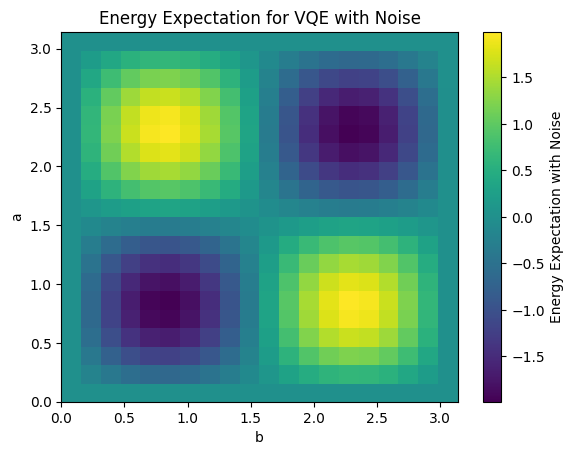

Minimum energy with noise: -1.9863613034027208 at a = 0.8267349088394192, b = 0.8267349088394192


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import transpile
from qiskit_aer.noise import NoiseModel, amplitude_damping_error, depolarizing_error
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator

# Define the Hamiltonian
H = SparsePauliOp.from_list([("XZ", -1), ("ZX", -1)])


# Prepare the grid search parameters
nmbr_points = 20
a_array = np.linspace(0, np.pi, nmbr_points)
b_array = np.linspace(0, np.pi, nmbr_points)
expectation_value_noisy = np.zeros((nmbr_points, nmbr_points))

# Backend setup
backend = AerSimulator()

# Define the noise model
p = 0.2
gamma = 0.1
noise_model = NoiseModel()
single_qubit_error = amplitude_damping_error(gamma, p)
two_qubit_error = depolarizing_error(0.01, 2)
noise_model.add_all_qubit_quantum_error(single_qubit_error, ['rz'])
noise_model.add_all_qubit_quantum_error(single_qubit_error, ['h'])
noise_model.add_all_qubit_quantum_error(two_qubit_error, ['cx'])

# Estimator with noise model
estimator = Estimator()

# Evaluate the energy expectation for each parameter set with noise
for a_id, a_val in enumerate(a_array):
    for b_id, b_val in enumerate(b_array):
        psi = parametrized_circuit(a_val, b_val)
        transpiled_psi = transpile(psi, backend)
        # Run the transpiled circuit on the backend with noise model
        result = estimator.run(transpiled_psi, H, noise_model=noise_model, backend_options={"backend_name": "aer_simulator"}).result()
        expectation_value_noisy[a_id, b_id] = result.values[0]

# Plot the heatmap with noise
plt.imshow(expectation_value_noisy, origin='lower', extent=[0, np.pi, 0, np.pi], aspect='auto', cmap='viridis')
plt.colorbar(label='Energy Expectation with Noise')
plt.title('Energy Expectation for VQE with Noise')
plt.xlabel('b')
plt.ylabel('a')
plt.show()

# Find the minimum energy state with noise
min_index_noisy = np.unravel_index(np.argmin(expectation_value_noisy), expectation_value_noisy.shape)
min_energy_noisy = expectation_value_noisy[min_index_noisy]
min_a_noisy = a_array[min_index_noisy[0]]
min_b_noisy = b_array[min_index_noisy[1]]

print(f"Minimum energy with noise: {min_energy_noisy} at a = {min_a_noisy}, b = {min_b_noisy}")